# This Notebook provides  

1. Comparative analysis of KModes v/s KMeans
2. Summarizes OER results based on KMeans and KModes results



# INSTALL PACKAGES

In [19]:
!pip install KModes

In [ ]:
!pip install yellowbrick

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 5.6 MB/s eta 0:00:00


# IMPORT PACKAGES

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn import metrics
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer
# from yellowbrick.cluster import InterclusterDistance
# from yellowbrick.cluster import SilhouetteVisualizer
from matplotlib.colors import ListedColormap
import seaborn as sns
import networkx as nx
import math
pd.set_option('display.max_columns', None)

# USER DEFINED FUNCTIONS

### Plot cluster distribution

In [22]:
def plot_cluster_distribution(clusters, plotTitle=""):
  cluster_sizes = np.bincount(clusters)
  total_clusters = len(clusters)
  percentages = (cluster_sizes / total_clusters) * 100
  plt.figure(figsize=(8, 6))
  plt.bar(range(len(cluster_sizes)), percentages, align='center', width=0.8)
  plt.xlabel('Cluster Size')
  plt.ylabel('Percentage')
  plt.title(plotTitle)
  plt.xticks(range(len(cluster_sizes)))

  plt.ylim(top=30)
  # Label x-axis ticks
  plt.xticks(range(len(cluster_sizes)))
  plt.show()

### Cluster Disease Percentage

In [23]:
def cluster_disease_percentage(clustering_result, patient_data, n, verbose=False):
  # Get unique cluster labels
  unique_clusters = np.unique(clustering_result)

  # Initialize an empty DataFrame to store disease percentages
  disease_percentage_df = pd.DataFrame(index=patient_data.columns, columns=unique_clusters)

  # Iterate over each cluster
  for cluster_id in unique_clusters:
      # Select patients in the current cluster
      cluster_patients = patient_data.iloc[clustering_result == cluster_id]
      disease_counts = cluster_patients.sum()
      # Calculate disease percentages for the cluster
      disease_percentages = (disease_counts / len(cluster_patients)) * 100
      formatted_percentages = disease_percentages.apply(lambda x: float("{:.2f}".format(x)))
      # Assign percentages to the DataFrame
      disease_percentage_df[cluster_id] = formatted_percentages

      if verbose:
          top_n_diseases = disease_percentages.sort_values(ascending=False).head(n).index

          print("Cluster " + str(cluster_id) + " Top Features")
          print(str(top_n_diseases.values))
          print("Cluster Size: " + str(len(cluster_patients)) + '\n')
  pd.set_option('display.max_columns', None)
  pd.set_option('display.max_rows', None)

  return disease_percentage_df

### Filter Cluster by demographics

In [24]:
def filter_cluster_by_demographics(disease_percentage_df, dems):
    filtered_disease_percentage_dfs = {}

    for cluster_id in disease_percentage_df.columns:
        cluster_df = disease_percentage_df[cluster_id]

        # Filter by the specified row indices in dems
        filtered_cluster_df1 = cluster_df[cluster_df.index.isin(dems)]
        filtered_cluster_df = filtered_cluster_df1.sort_values(ascending=False)

        # getting the index data
        index = filtered_cluster_df.index
        # removing duplicate indices separately
        filtered_cluster_df = filtered_cluster_df[~index.duplicated(keep="first")]
        filtered_disease_percentage_dfs[cluster_id] = filtered_cluster_df

    return filtered_disease_percentage_dfs

def plot_cluster_demographics_separately(filtered_data, variable_subsets, subset_titles):
    for cluster_id, cluster_df in filtered_data.items():
        num_subplots = len(variable_subsets)
        num_rows = (num_subplots + 1) // 2  # Calculate the number of rows needed

        fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))
        fig.suptitle(f'Cluster {cluster_id}', fontsize=16)

        if num_rows == 1:
            axes = [axes]  # Convert to list if only one row

        for i, ax_row in enumerate(axes):
            for j, vars in enumerate(variable_subsets[i * 2:i * 2 + 2]):
                subset_df = cluster_df[cluster_df.index.isin(vars)]
                rounded_values = subset_df.round().astype(int)
                bars = ax_row[j].bar(rounded_values.index, rounded_values, width=0.7)
                ax_row[j].set_title(subset_titles[i * 2 + j])
                ax_row[j].set_xlabel('Demographics')
                ax_row[j].set_ylabel('Percentage')
                ax_row[j].tick_params(axis='x', rotation=85)
                ax_row[j].set_ylim(0, 100)  # Set the y-axis limit to 0-100

                # Annotate bars with exact percentages
                for bar in bars:
                    height = bar.get_height()
                    ax_row[j].text(
                        bar.get_x() + bar.get_width() / 2,
                        height,
                        f'{height}%',
                        ha='center',
                        va='bottom'
                    )

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

### Run KModes

In [25]:
def run_k_modes(data, n_clusters, n_init):
    km = KModes(n_clusters=n_clusters, init='random', n_init=n_init)
    clusters = km.fit_predict(data)
    return clusters

### Run KMeans

In [26]:
def run_k_means(data, n_clusters, n_init):
    km = KMeans(n_clusters=n_clusters, init='random', n_init=n_init)
    clusters = km.fit_predict(data)
    return clusters

### Plot Silhouettes

In [27]:
def plot_silhouettes(data, clusters, metric='hamming'):
    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = metrics.silhouette_samples(data, clusters, metric='hamming')
    c_ax_lower, c_ax_upper = 0, 0
    cticks = []
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[clusters == k]
        c_silhouette_vals.sort()
        c_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(c_ax_lower, c_ax_upper), c_silhouette_vals, height=1.0,
                      edgecolor='none', color=color)

        cticks.append((c_ax_lower + c_ax_upper) / 2)
        c_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")

    plt.yticks(cticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.tight_layout()
    plt.show()

    return

## Observed Expected Ratio

#### Calculate Disease Prevalence

In [28]:
def calculate_disease_prevalence(df, clustering_labels):
  cluster_prevalence = {}
  unique_clusters = np.unique(clustering_labels)

  for cluster in unique_clusters:
    # print(cluster)
    # Subset the DataFrame for the current cluster
    # if cluster == 7:
    cluster_df = df[clustering_labels == cluster]

    # Calculate the prevalence (sum) of each disease in the cluster
    prevalence = cluster_df.sum()
    # Store the prevalence in the dictionary
    cluster_prevalence[cluster] = prevalence

      # # Convert the dictionary to a DataFrame
      # prevalence_df = pd.DataFrame(cluster_prevalence)
  return cluster_prevalence

#### Calculate Population Disease Prevalence

In [29]:
def calculate_population_disease_prevalence(df, pop_size):
    # Calculates population-wise percentage disease prevalence
    prevalence = df.sum()
    return prevalence/pop_size

#### Calculate Population Expected Coexistence

In [30]:
def calculate_population_expected_coexistence(pop_disease_prevalence, debug_mode=False):
    # Calculate the expected coexistence matrix
    # Taking the outer product of two vectors: Outer product of disease_prevalence with itself,
    # we create a matrix where the entry at position (i, j) is the product of the prevalence
    # of disease i and the prevalence of disease j.

    expected_coexistence = np.outer(pop_disease_prevalence, pop_disease_prevalence)
    if debug_mode:
        print(f"expected_coexistence: {expected_coexistence}")
        print(expected_coexistence.shape)
    return expected_coexistence

#### Calculate OER

In [31]:
def calculate_oer(df, clustering_labels, expected_coexistence, debug_mode=False):
  # Initialize a dictionary to store the OER values for each cluster
  cluster_oers = {}

  # Iterate over each unique cluster
  for cluster in np.unique(clustering_labels):

    # Subset the dataframe to include only the patients in the current cluster
    cluster_df = df[clustering_labels == cluster]
#         if debug_mode:
#             print(f"cluster_df: {cluster_df}")

    # Multiplying the transposed DataFrame (cluster_df.T) with the original DataFrame (cluster_df),
    # we get a new matrix where the entry at position (i, j) represents the count of patients that have
    # both disease i and disease j
    observed_coexistence = (cluster_df.T @ cluster_df) / len(cluster_df)
#         if debug_mode:
#             print(f"observed_coexistence: {observed_coexistence}")
#             print(f"expected_coexistence: {expected_coexistence}")

    #Calculate the OER matrix
    observed_coexistence.fillna(0.0, inplace=True)
    oer_matrix = observed_coexistence / expected_coexistence

    if debug_mode:
        print(f"oer_matrix: {oer_matrix}")

    # Store the OER matrix in the dictionary
    cluster_oers[cluster] = oer_matrix

  return cluster_oers

#### Plot OER

In [32]:
def plot_oer(oer_matrix_dictionary, clusterNumber):
  rows = []
  #print(oer_matrix_dictionary)
  # Iterate through the clusters in the cluster_oers dictionary
  for cluster, oer_matrix in oer_matrix_dictionary.items():
      # Iterate over the rows and columns of the OER matrix
      for i in range(oer_matrix.shape[0]):
          for j in range(i + 1, oer_matrix.shape[1]):

            disease1 = oer_matrix.index[i]
            disease2 = oer_matrix.columns[j]
            oer_score = oer_matrix.iat[i, j]

            # Add the row to the list
            rows.append({'Cluster': cluster, 'disease1': disease1, 'disease2': disease2, 'OER': oer_score})

  # Convert the list of rows into a DataFrame
  oer_df = pd.DataFrame(rows)
  filtered_df = oer_df[(oer_df['OER'] > 1) & (oer_df['Cluster'] == clusterNumber)]

  # Pivot the data to create a matrix format suitable for a heatmap
  oer_matrix = filtered_df.pivot(index='disease1', columns='disease2', values='OER')

  # Plot the heatmap
  plt.figure(figsize=(12, 8))
  sns.heatmap(oer_matrix, annot=True, cmap='coolwarm', cbar=True, linewidths=.5)
  plt.title(f'OER Heatmap for Cluster {clusterNumber}')
  plt.show()

#### Plot Disease Graph

In [33]:
def plot_disease_graphs(cluster_oers, disease_prevalence, clust_size, prevalence_threshold=0.1, oer_threshold=1):
    for cluster, oer_matrix in cluster_oers.items():
        G = nx.Graph()

        # Filter diseases based on prevalence threshold
        prevalent_diseases = disease_prevalence[cluster][disease_prevalence[cluster] >= (clust_size[cluster]*prevalence_threshold)].index

        # Add nodes
        for disease in prevalent_diseases:
            G.add_node(disease)

        # Add edges with OER as weight
        for i, disease_i in enumerate(prevalent_diseases):
            for j, disease_j in enumerate(prevalent_diseases):
                if i < j:  # To avoid duplicate edges and self-loops
                    oer_value = oer_matrix.loc[disease_i, disease_j]
                    if oer_value >= oer_threshold:  # Optional threshold for OER to include significant edges
                        G.add_edge(disease_i, disease_j, weight=oer_value)

        # Plot the graph with padding
        plt.figure(figsize=(12, 9))
        pos = nx.spring_layout(G)  # Layout for the graph
        edges = G.edges(data=True)
        weights = [edge[2]['weight'] for edge in edges]

        # Calculate edge widths based on OER values
        if weights:
            max_weight = max(weights)
            min_weight = min(weights)
            if max_weight == min_weight:
                edge_widths = [1] * len(weights)  # Set a default width if all weights are the same
            else:
                edge_widths = [1 + 5 * ((w - min_weight) / (max_weight - min_weight)) for w in weights]
        else:
            edge_widths = [1] * len(edges)  # Default width if no edges

        # Draw nodes and edges
        options = {"edgecolors": "tab:gray", "node_size": 600, "alpha": 0.9}
        nx.draw_networkx_nodes(G, pos, node_color="whitesmoke", **options)
        nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif", font_color="black")
        nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="tab:blue", alpha=0.8)  # Edge thickness based on scaled OER

        # Draw edge labels (OER values)
        edge_labels = {(disease_i, disease_j): f"{G[disease_i][disease_j]['weight']:.2f}" for disease_i, disease_j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=8)

        # Add padding around the plot
        plt.margins(x=0.3, y=0.2)
        plt.axis("off")
        plt.title(f"Disease Network for Cluster {cluster}")
        plt.show()

#### Cluster Size

In [34]:
def cluster_sizes(labels):
    cluster_dict = {}
    for label in labels:
        if label in cluster_dict:
            cluster_dict[label] += 1
        else:
            cluster_dict[label] = 1
    return cluster_dict

#### Verify OER

In [35]:
def verify_oer():
  pass

# LOAD DATASETS

In [41]:
# Import data for clustering
syndemics_data = pd.read_csv("/data/syndemics_synthetic_diseases_only_data.csv")
print(syndemics_data.shape)

(93994, 30)


In [43]:
syndemics_data.sum()

,0
Acute Myocardial Infarction,630
Alzheimer’s Disease,585
Anemia,16941
Asthma,11616
Atrial Fibrillation and Flutter,3720
Benign Prostatic Hyperplasia,4465
"Cancer, Breast",2549
"Cancer, Colorectal",743
"Cancer, Endometrial",375
"Cancer, Lung",674


In [ ]:
# Import data for cluster analysis
analysis_syndemics_data = pd.read_csv("/data/Syndemics_dummy_data.csv")

# Remove prefix from race ethnicity
analysis_syndemics_data = analysis_syndemics_data.rename(columns=lambda x: x.replace('race_ethnicity_', '') if x.startswith('race_ethnicity_') else x)
print(analysis_syndemics_data.shape)

# EXPERIMENTS

## Optimal k value

### KModes : Optimal k value

In [ ]:

# Elbow curve to find optimal K
cost = []
K = [i for i in range(1,21)]

for num_clusters in K:
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5)
    kmode.fit_predict(syndemics_data)
    cost.append(kmode.cost_)

plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
# Set x-axis ticks to display whole numbers only
plt.xticks(K)
plt.show()

### KMeans : Optimal k value

In [ ]:

max_number_of_clusters = 21

K=[i for i in range(1,max_number_of_clusters)]
kmeans_inertia=[]

for num_cluster in K:
  kmeans = KMeans(n_clusters=num_cluster, n_init = 5, init = 'random')
  kmeans.fit_predict(syndemics_data)
  kmeans_inertia.append(kmeans.inertia_)

# Elbow plot
plt.figure(figsize=(10,6))
plt.plot(K,kmeans_inertia,'b.-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Optimal K (number of cluster)')
# Set x-axis ticks to display whole numbers only
plt.xticks(K)
plt.show()

## Execute KModes, KMeans with optimal k value

### KModes : Clustering with k=16



In [ ]:
# Clustering with k=16
kmodes_16 = KModes(n_clusters=16, init = "random", n_init = 5, random_state=42)
kmodes_clusters_16 = kmodes_16.fit_predict(syndemics_data)

In [ ]:
# Save results in a csv file
# convert clustering results to a DataFrame
kmodes_clusters_df = pd.DataFrame(kmodes_clusters_16, columns=['Clsuter'])

# Concatenate the original data with the clustering results
kmodes_results_df = pd.concat([syndemics_data.reset_index(drop=True), kmodes_clusters_df], axis=1)
kmodes_results_df.to_csv("/data/"+'syndemics_data_with_kmodes_clusters.csv', index=False)

### KMeans : Clustering with k=16


In [ ]:
# Clustering with k=16
kmeans = KMeans(n_clusters=16, init='random', n_init=5, random_state=42)
kmeans_clusters_16 = kmeans.fit_predict(syndemics_data)

In [ ]:
# Save results in a csv file
# convert clustering results to a DataFrame
kmeans_clusters_df = pd.DataFrame(kmeans_clusters_16, columns=['Clsuter'])

# Concatenate the original data with the clustering results
kmeans_results_df = pd.concat([syndemics_data.reset_index(drop=True), kmeans_clusters_df], axis=1)
kmeans_results_df.to_csv("/data/"+'syndemics_data_with_kmeans_clusters.csv', index=False)

# EVALUATE RESULTS

## ARI Score

### KModes - ARI Score : k = 16

In [ ]:
n_clusters = 16
n_init = 10  # Number of initializations
n_runs = 70  # Number of times to run the clustering

cluster_assignments = []
for _ in range(n_runs):
    clusters = run_k_modes(syndemics_data, n_clusters, n_init)
    cluster_assignments.append(clusters)

n = len(cluster_assignments)
scores = []

for i in range(n):
    for j in range(i + 1, n):
        score = adjusted_rand_score(cluster_assignments[i], cluster_assignments[j])
        scores.append(score)

# Calculate the average Adjusted Rand Score
average_score = np.mean(scores)
print(f'Average Adjusted Rand Score: {average_score}')

Average Adjusted Rand Score: 0.4992596043662974


### KMeans - ARI Score : k = 16

In [ ]:
n_clusters = 16
n_init = 10  # Number of initializations
n_runs = 70  # Number of times to run the clustering

cluster_assignments = []
for _ in range(n_runs):
    clusters = run_k_means(syndemics_data, n_clusters, n_init)
    cluster_assignments.append(clusters)

n = len(cluster_assignments)
scores = []

for i in range(n):
    for j in range(i + 1, n):
        score = adjusted_rand_score(cluster_assignments[i], cluster_assignments[j])
        scores.append(score)

# Calculate the average Adjusted Rand Score
average_score = np.mean(scores)
print(f'Average Adjusted Rand Score: {average_score}')

Average Adjusted Rand Score: 0.5550690452315705


## Silhouette Score

### KModes : Silhouette Score

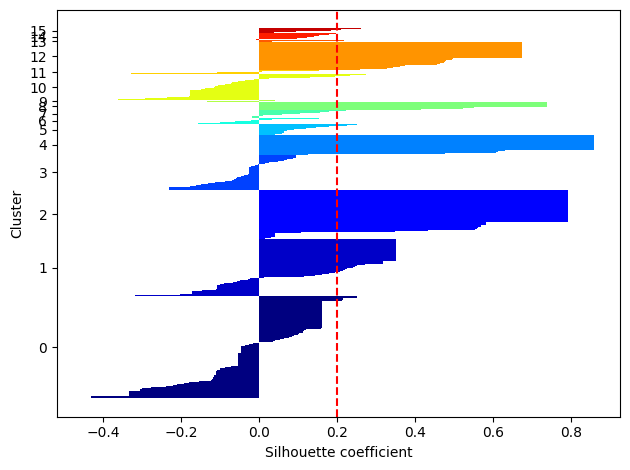

In [ ]:
plot_silhouettes(syndemics_data, kmodes_clusters_16, metric='hamming')

### KMeans : Silhouette Score

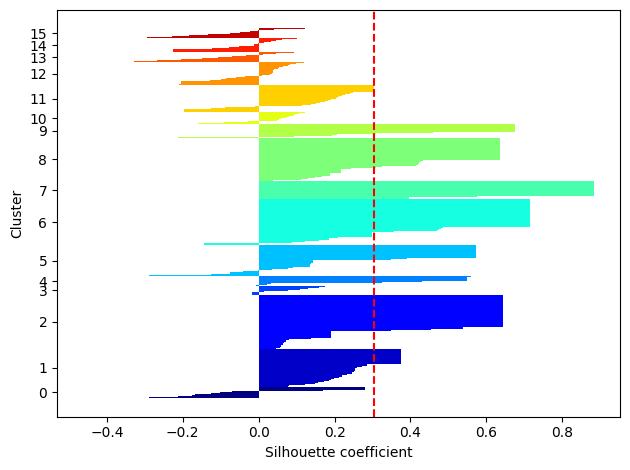

In [ ]:
plot_silhouettes(syndemics_data, kmeans_clusters_16, metric='hamming')

## Plot cluster distribution

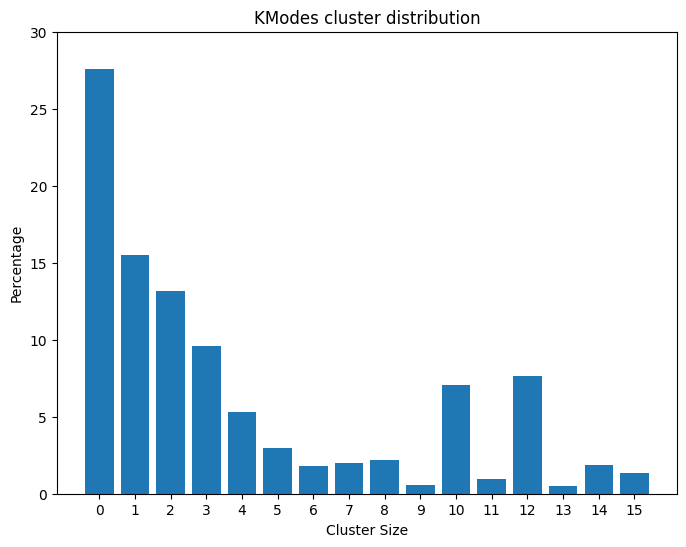

In [ ]:
# Plotting the distribution of clusters
plot_cluster_distribution(kmodes_clusters_16, plotTitle="KModes cluster distribution")

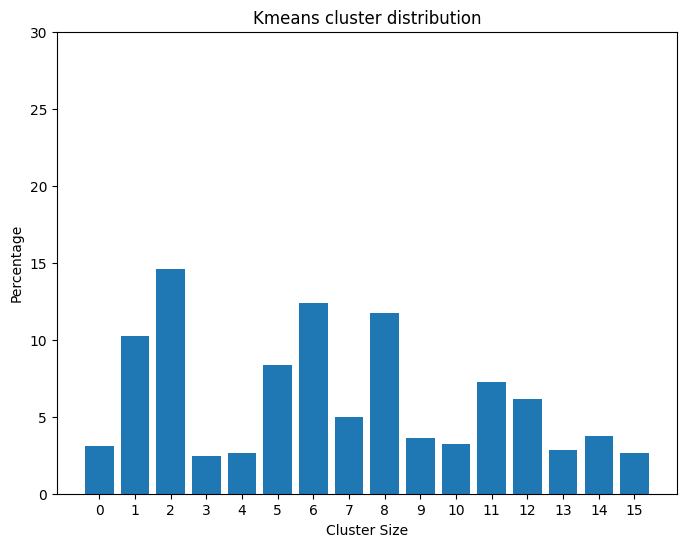

In [ ]:
# Plotting the distribution of clusters
plot_cluster_distribution(kmeans_clusters_16, plotTitle="Kmeans cluster distribution")

## Cluster Summary Plots Per Demographic Characteristic

In [ ]:
sexes = ["SEX_F", "SEX_M"]
age = ["age_bin_18-24", "age_bin_25-44", "age_bin_45-64", "age_bin_65-74", "age_bin_75-104"]
race_ethnicity = ["Asian, Hispanic", "Asian, No Information",
                  "Asian, Not Hispanic", "Asian, Refuse to Answer",
                  "Black or African American, Hispanic", "Black or African American, No Information",
                  "Black or African American, Not Hispanic", "Black or African American, Refuse to Answer",
                  "OT, Hispanic", "OT, No Information", "OT, Not Hispanic",
                  "OT, Refuse to Answer", "White, Hispanic", "White, No Information",
                  "White, Not Hispanic", "White, Refuse to Answer"]
pcvc = ["pcvc_bin_1-4", "pcvc_bin_5-8", "pcvc_bin_9-12", "pcvc_bin_13-16",
        "pcvc_bin_17-20", "pcvc_bin_21-24", "pcvc_bin_25+"]
dems = sexes + age + pcvc + race_ethnicity
variable_subsets = [
    sexes,
    age,
    race_ethnicity,
    pcvc
]

subset_titles = ["Sex", "Age", "Race/Ethnicity", "PCVC", "Race & Ethnicity", "Insurance"]

### KModes : Cluster Summary Plots Per Demographic Characteristic

In [ ]:
# Percentages of features per cluster - top 10
disease_prct_clusters = cluster_disease_percentage(kmodes_clusters_16, analysis_syndemics_data, 10, verbose=True)

clusters_demographics_prct = filter_cluster_by_demographics(disease_prct_clusters, dems)
plot_cluster_demographics_separately(clusters_demographics_prct, variable_subsets, subset_titles)

Output hidden; open in https://colab.research.google.com to view.

### KMeans : Cluster Summary Plots Per Demographic Characteristic

In [ ]:
# Percentages of features per cluster - top 10
disease_prct_clusters = cluster_disease_percentage(kmeans_clusters_16, analysis_syndemics_data, 10, verbose=True)

clusters_demographics_prct = filter_cluster_by_demographics(disease_prct_clusters, dems)
plot_cluster_demographics_separately(clusters_demographics_prct, variable_subsets, subset_titles)

Output hidden; open in https://colab.research.google.com to view.

## OER Calculation and Graph Generation

### KModes : OER Calculation

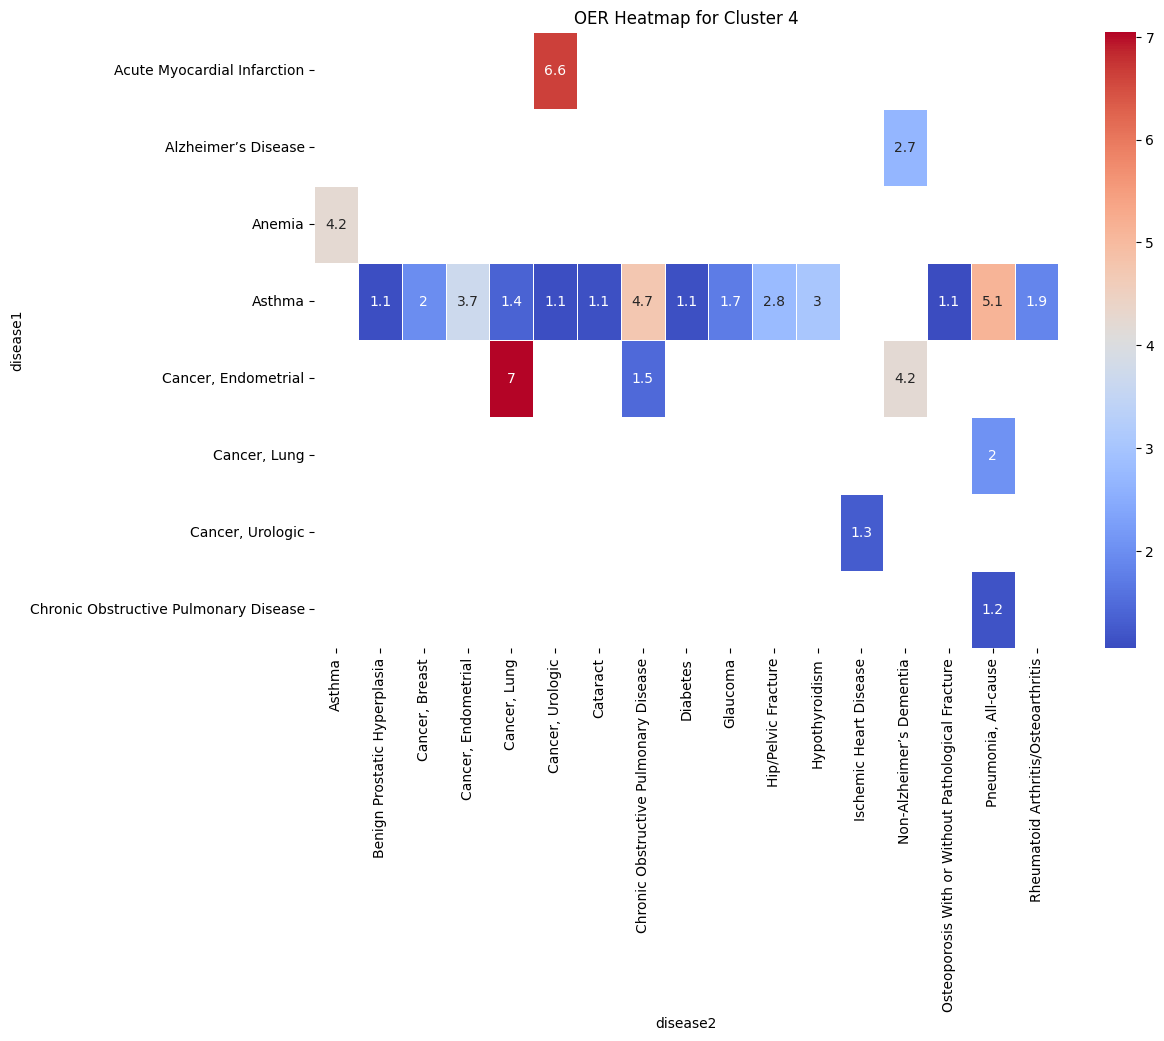

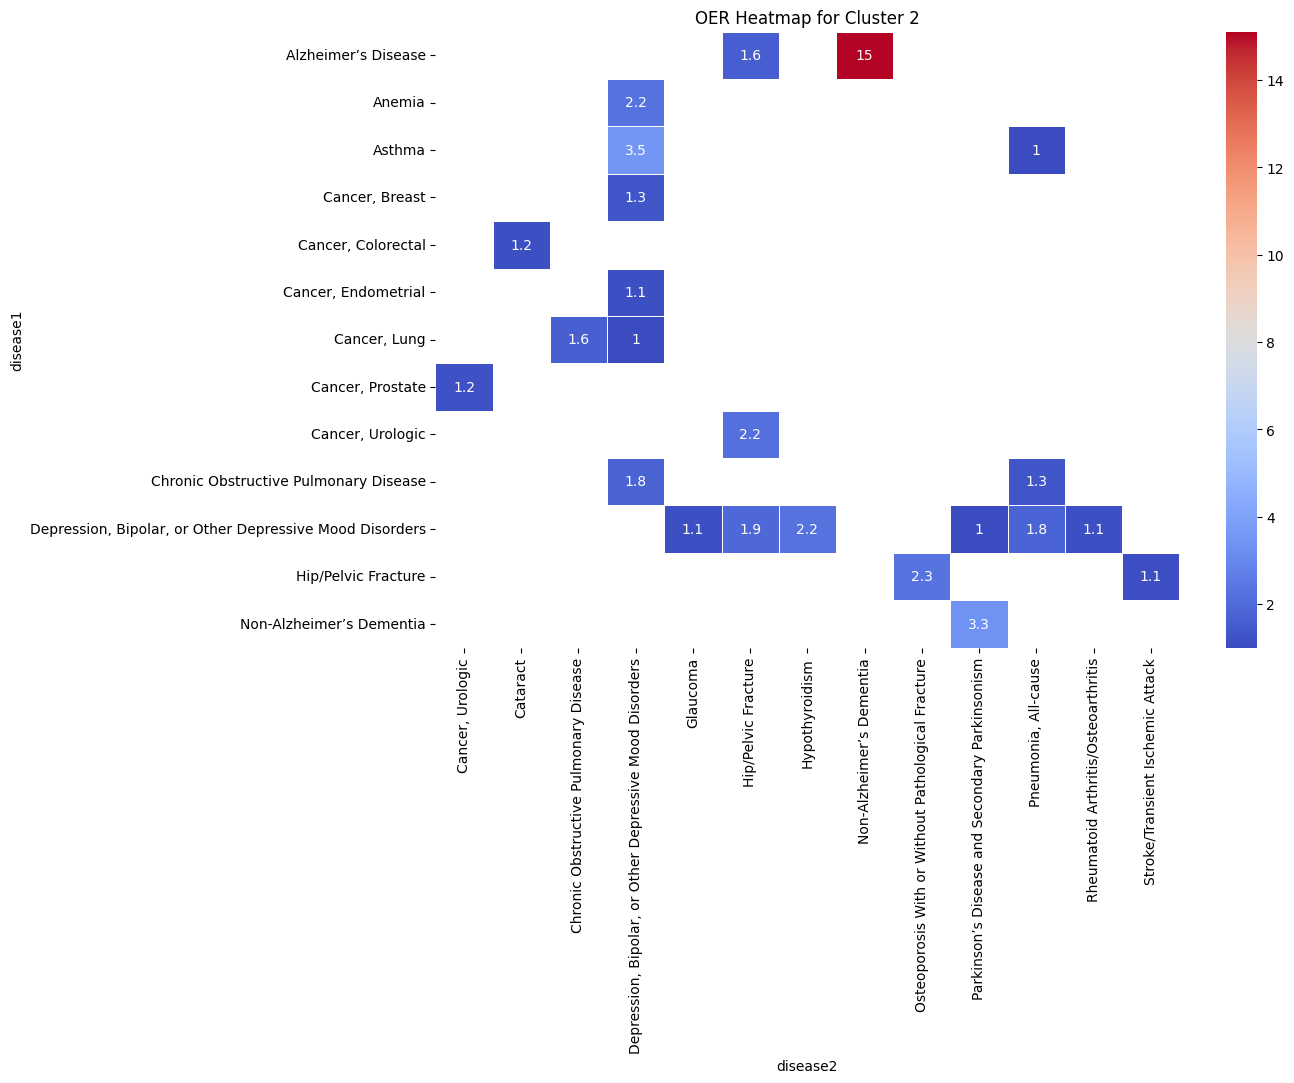

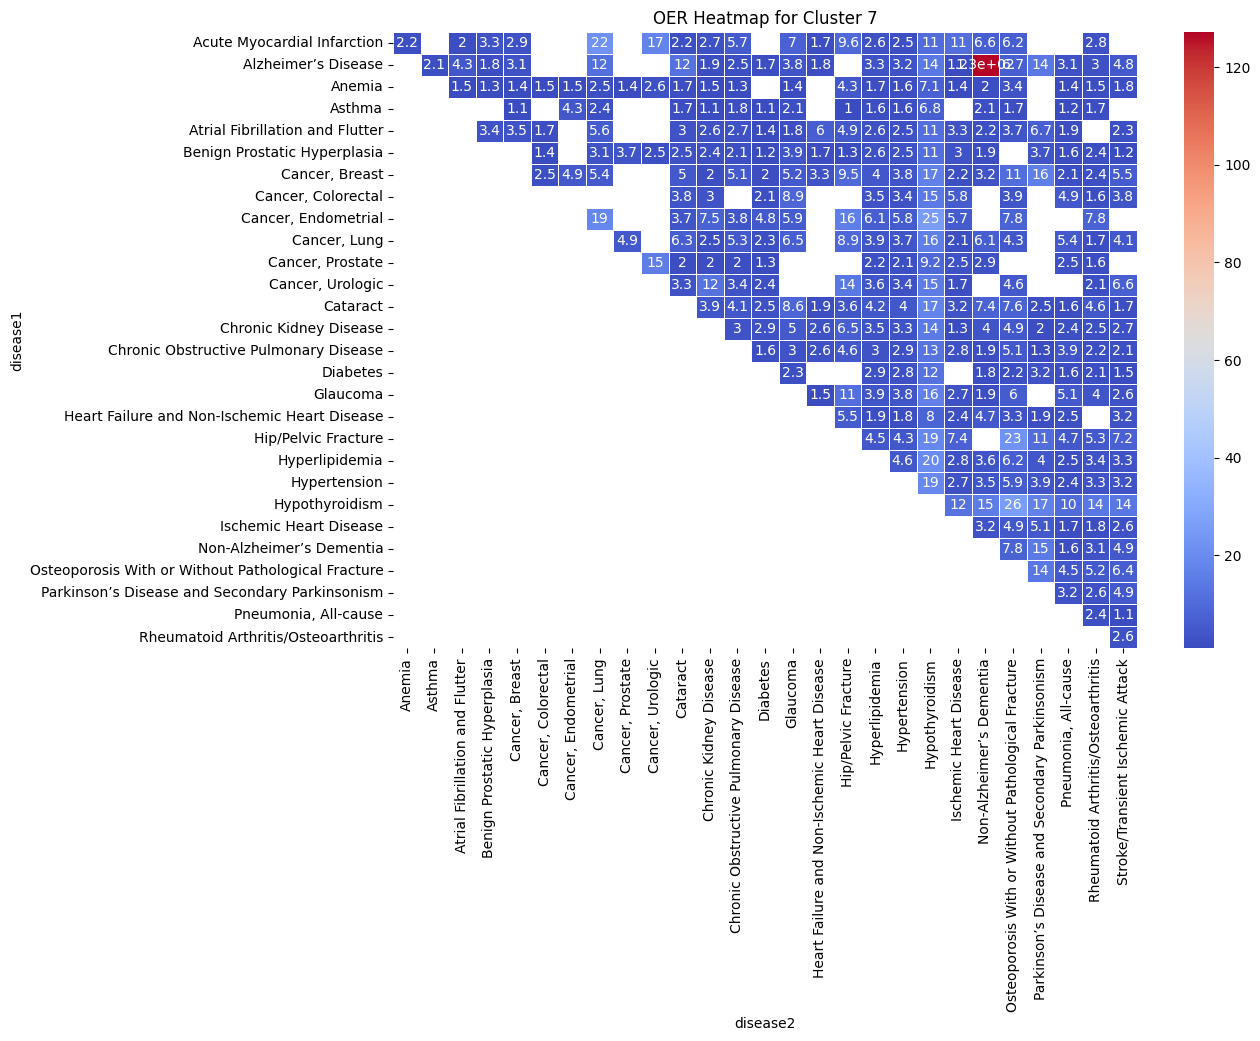

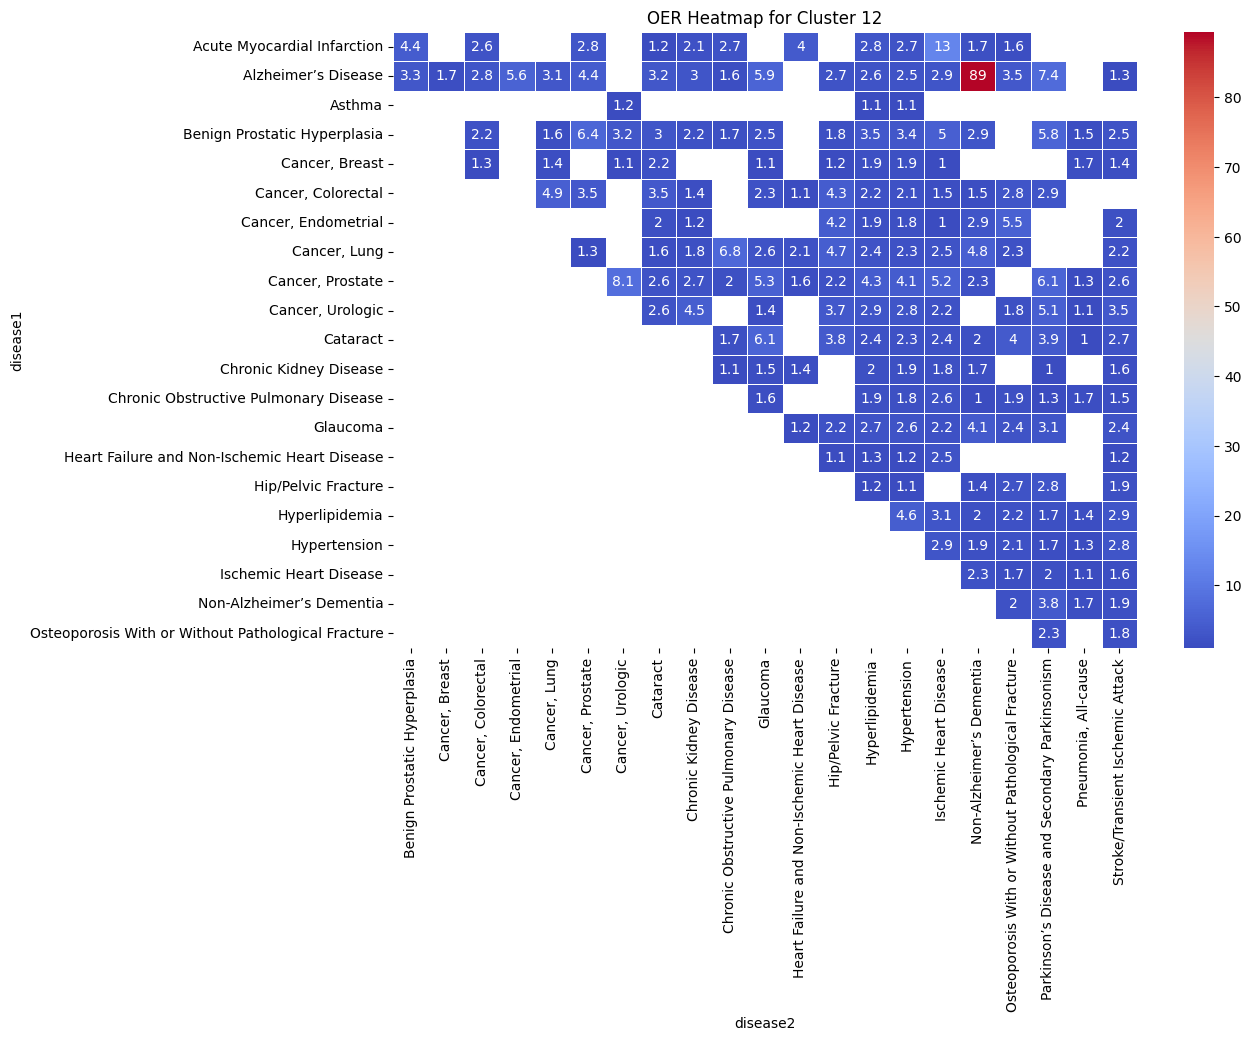

In [ ]:
disease_prevalence_kmodes= calculate_disease_prevalence(syndemics_data, kmodes_clusters_16)
pop_disease_prevalence_kmodes = calculate_population_disease_prevalence(syndemics_data, syndemics_data.shape[0])
expected_coexistence_kmodes = calculate_population_expected_coexistence(pop_disease_prevalence_kmodes, debug_mode=False)
oer_16_kmodes = calculate_oer(syndemics_data, kmodes_clusters_16, expected_coexistence_kmodes, debug_mode=False)

plot_oer(oer_16_kmodes,4)

plot_oer(oer_16_kmodes,2)

plot_oer(oer_16_kmodes,7)

plot_oer(oer_16_kmodes,12)

#oer_16_kmodes

### KModes: Plot Disease Graph

In [ ]:
clust_size = cluster_sizes(kmodes_clusters_16)
plot_disease_graphs(oer_16_kmodes, disease_prevalence_kmodes, clust_size, prevalence_threshold=0.1)
clust_size

Output hidden; open in https://colab.research.google.com to view.

### KMeans : OER Calculation

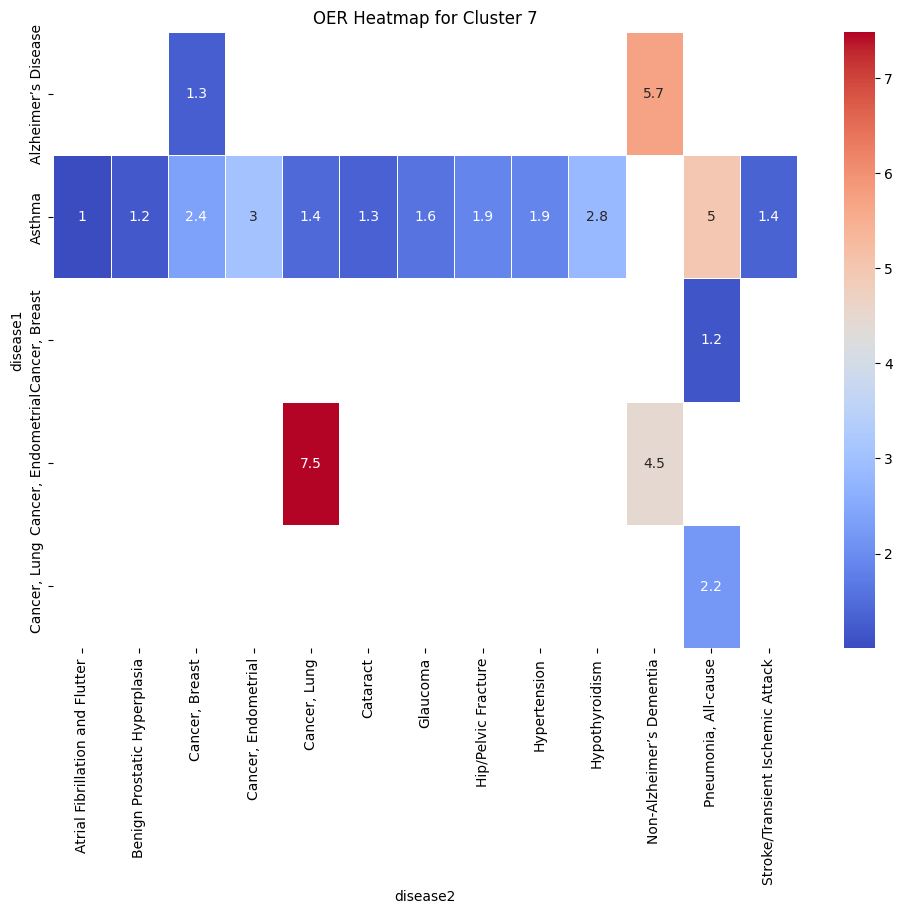

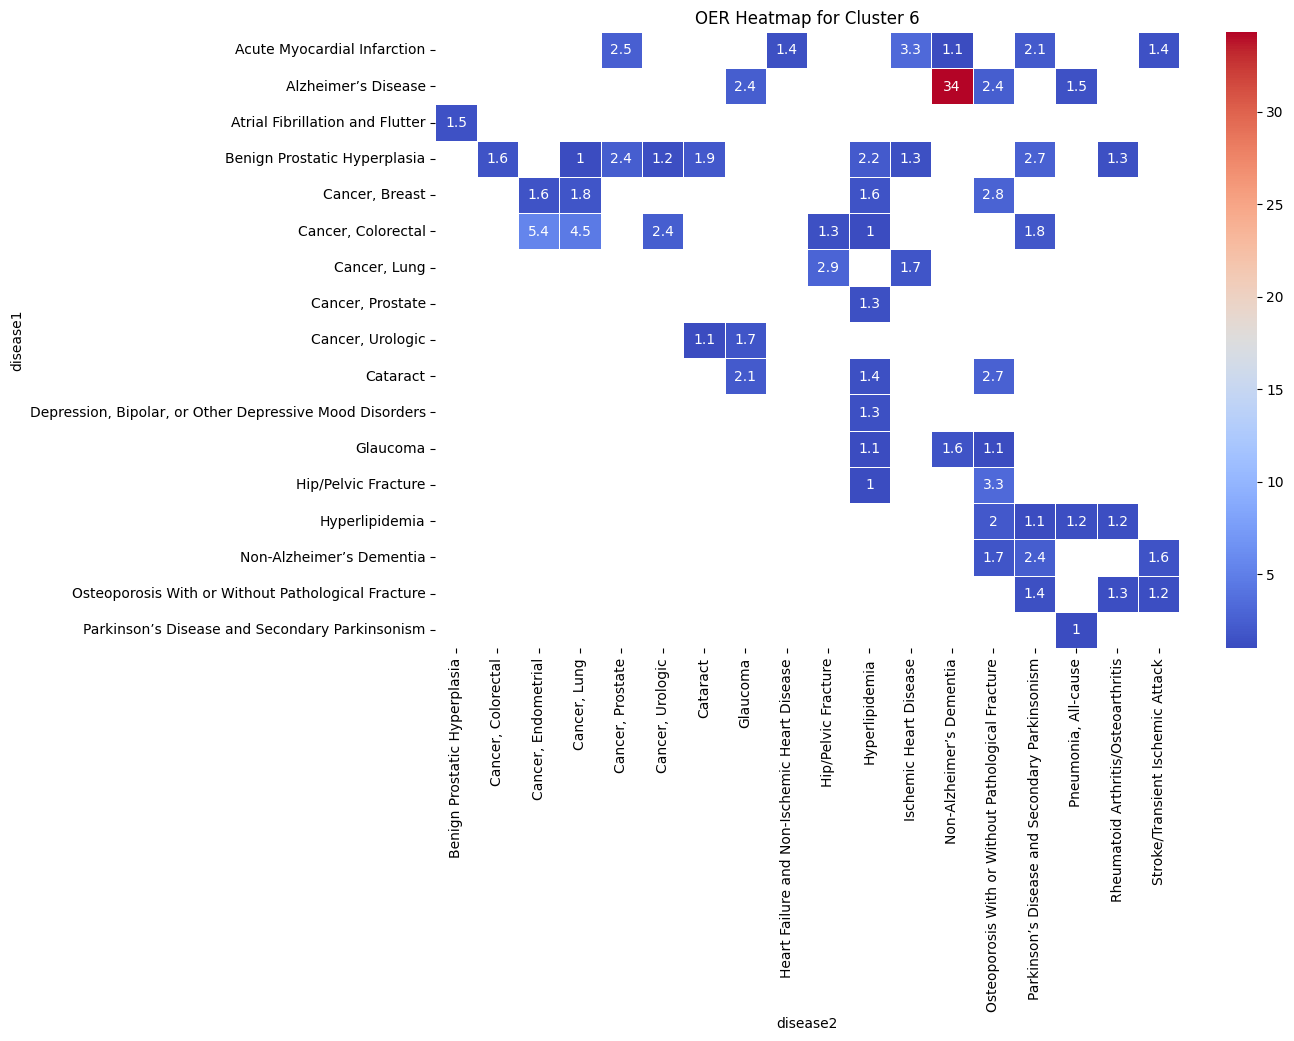

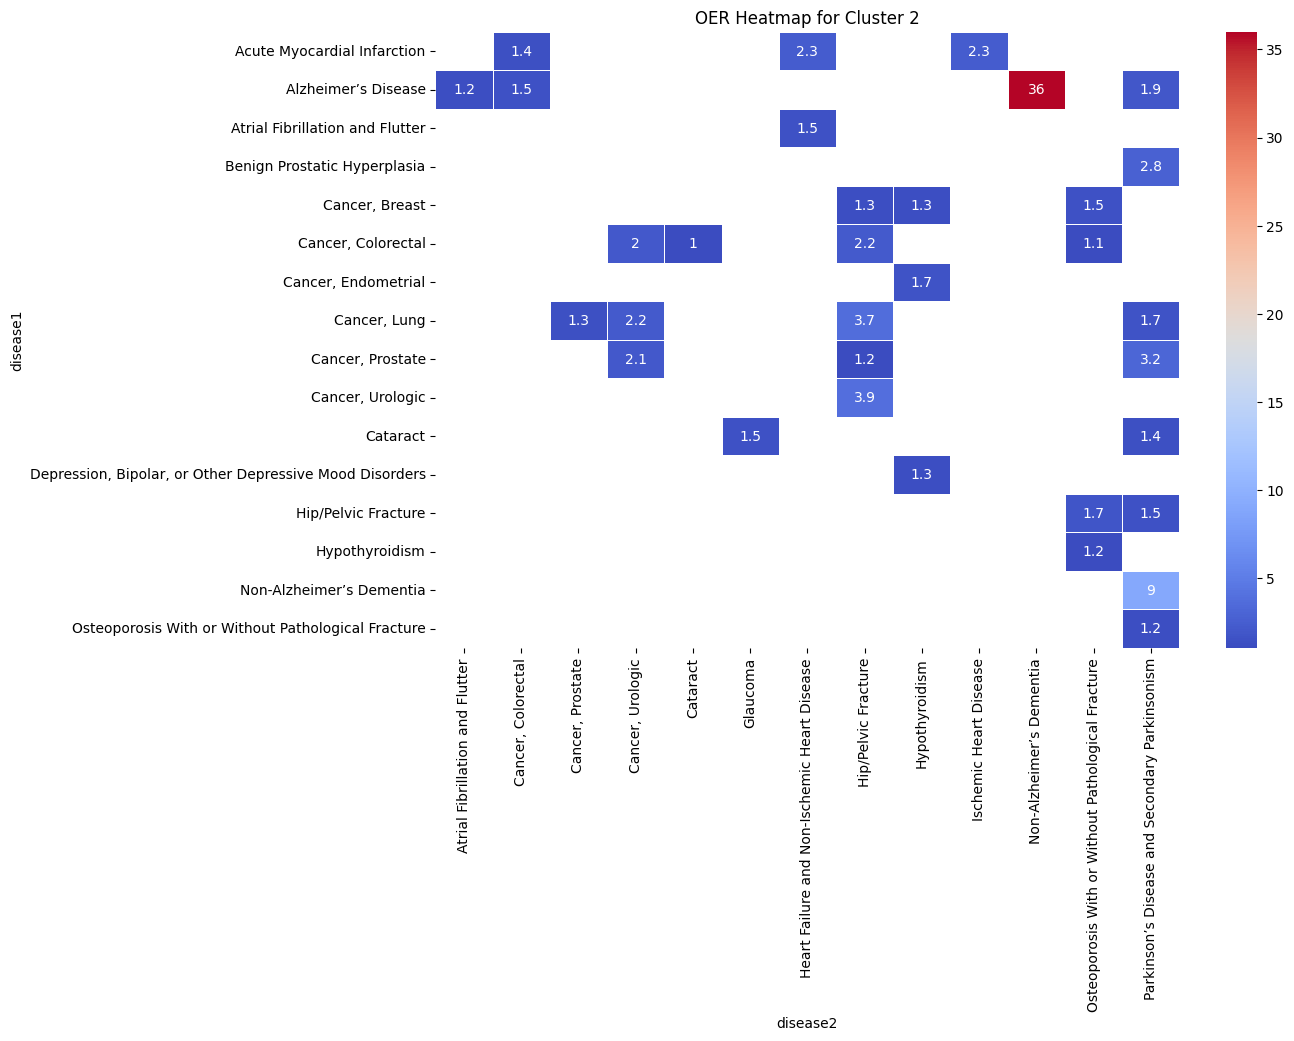

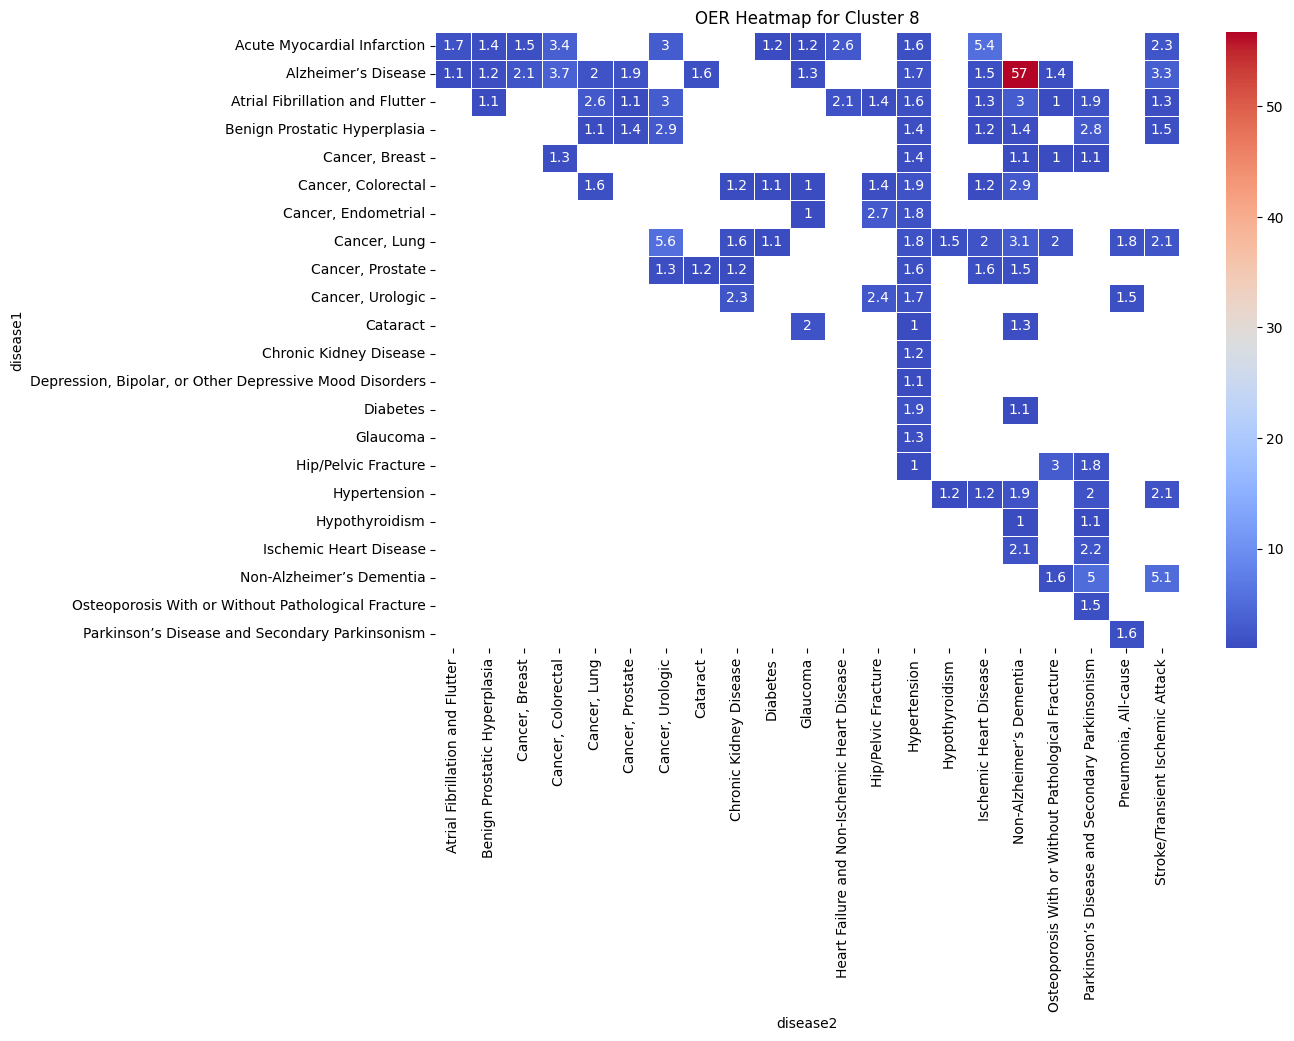

In [ ]:
disease_prevalence_kmeans= calculate_disease_prevalence(syndemics_data, kmeans_clusters_16)
pop_disease_prevalence_kmeans = calculate_population_disease_prevalence(syndemics_data, syndemics_data.shape[0])
expected_coexistence_kmeans = calculate_population_expected_coexistence(pop_disease_prevalence_kmeans, debug_mode=False)
oer_16_kmeans = calculate_oer(syndemics_data, kmeans_clusters_16, expected_coexistence_kmeans, debug_mode=False)
plot_oer(oer_16_kmeans,7)
plot_oer(oer_16_kmeans,6)
plot_oer(oer_16_kmeans,2)
plot_oer(oer_16_kmeans,8)

### KMeans : Plot Disease graphs

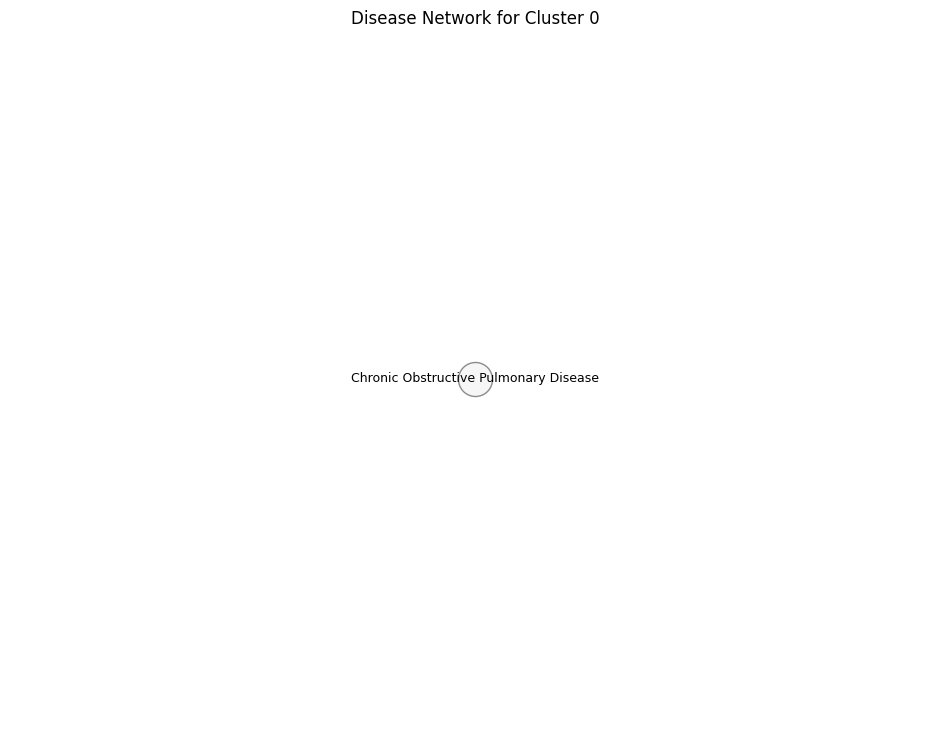

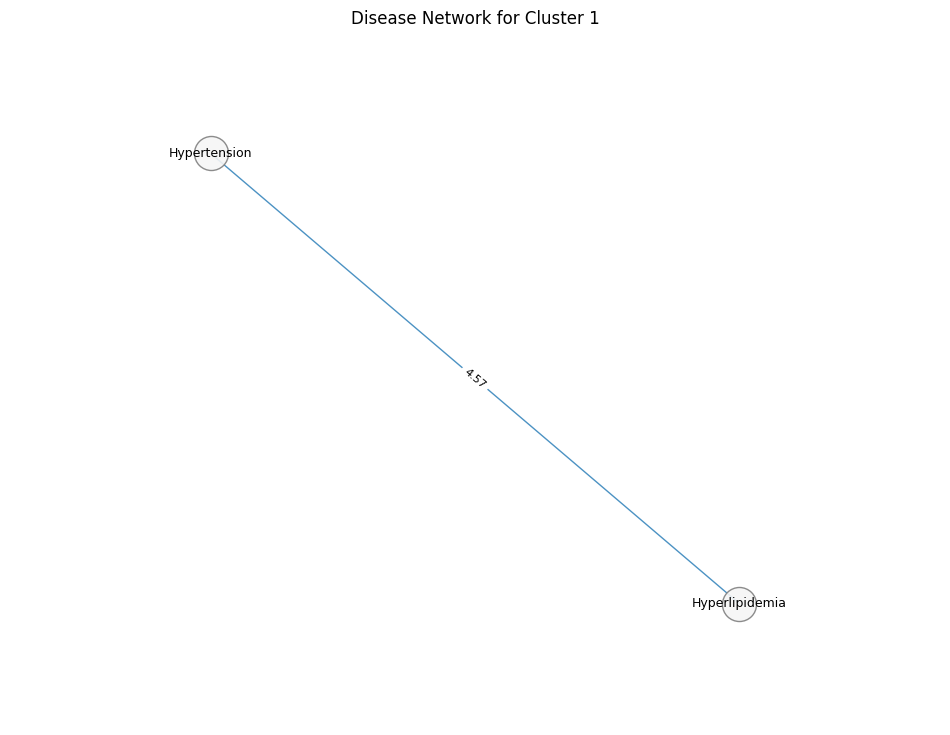

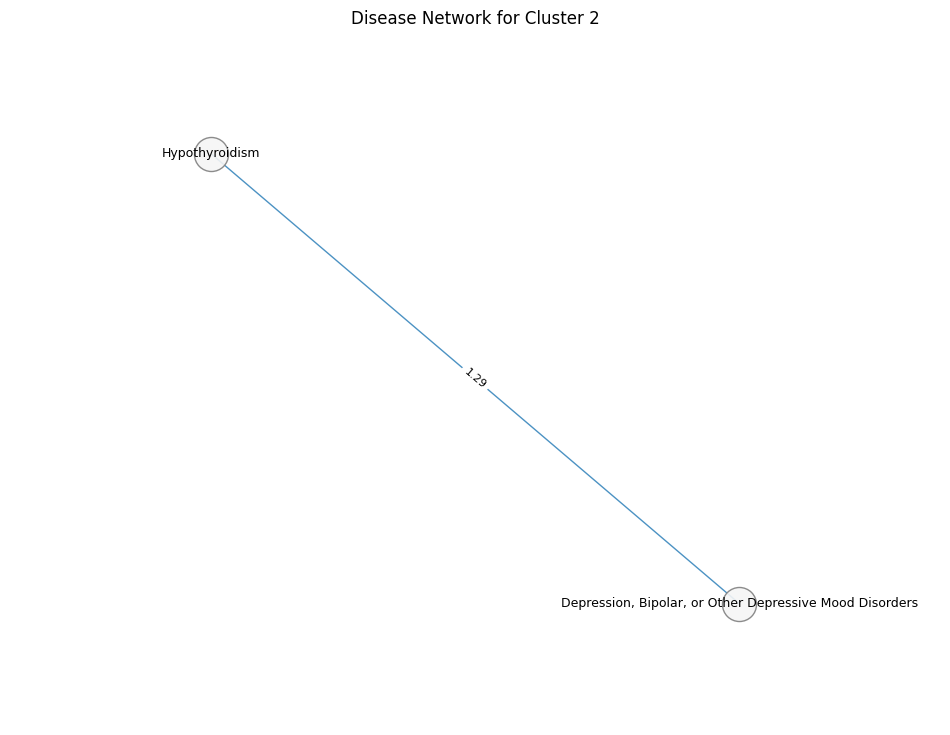

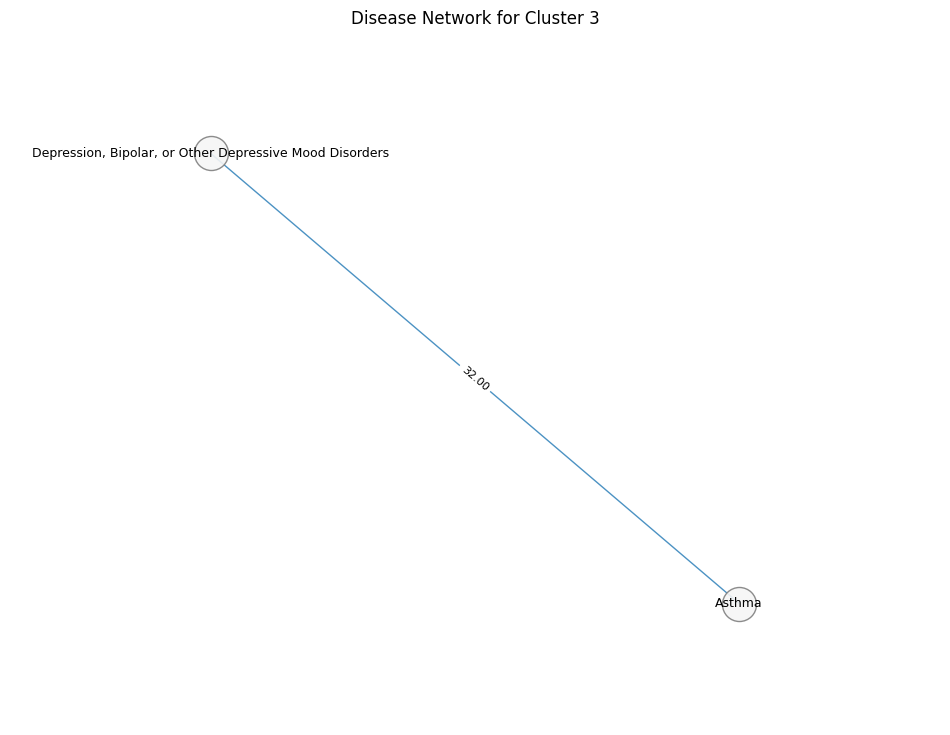

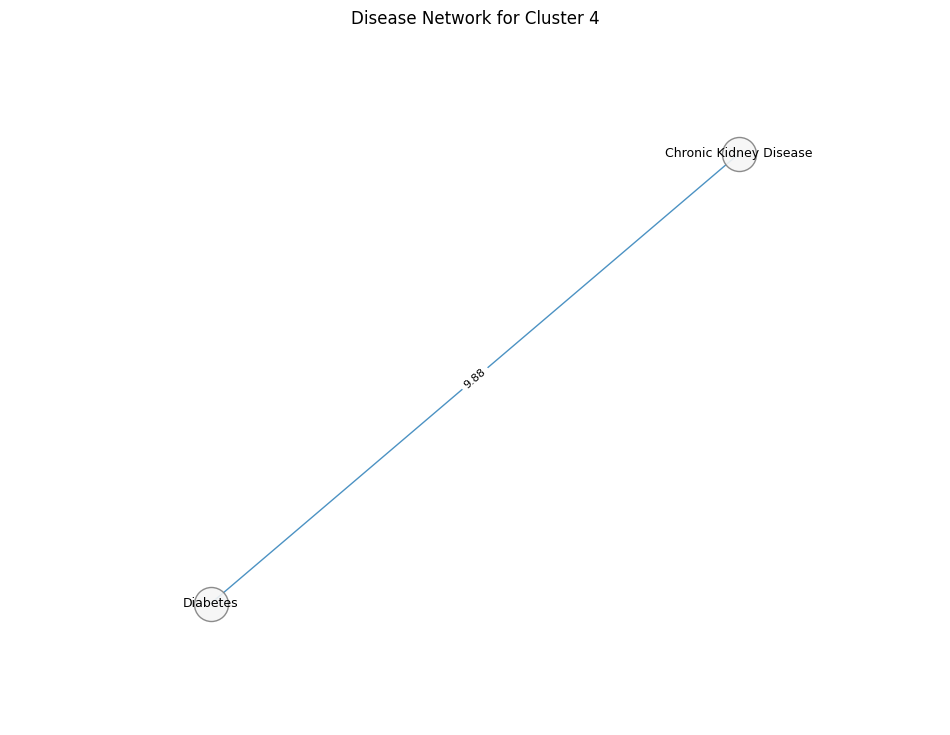

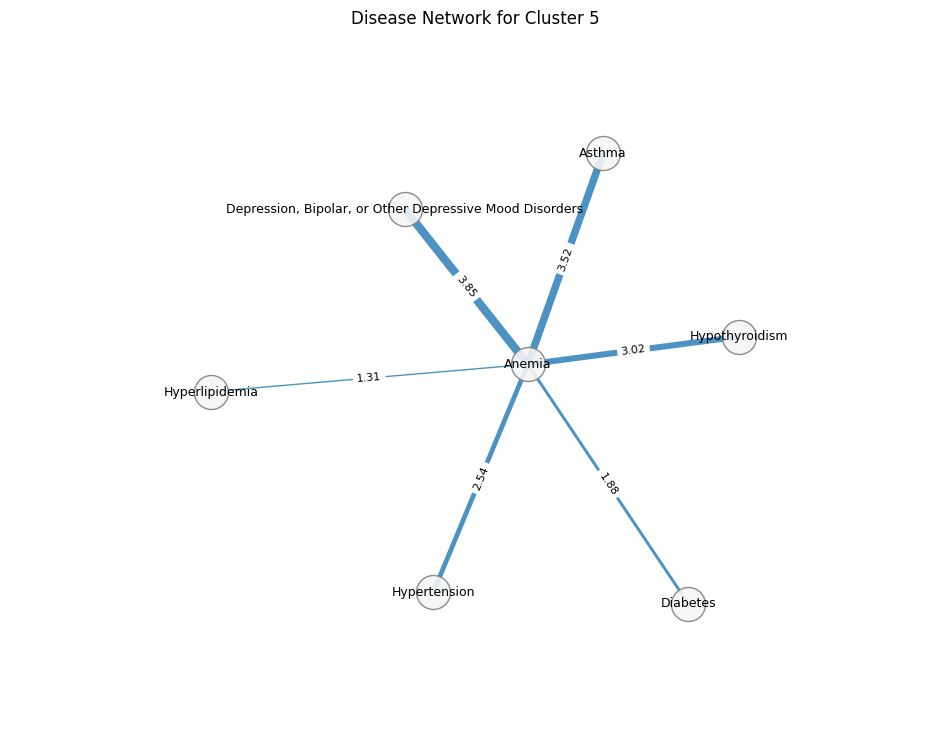

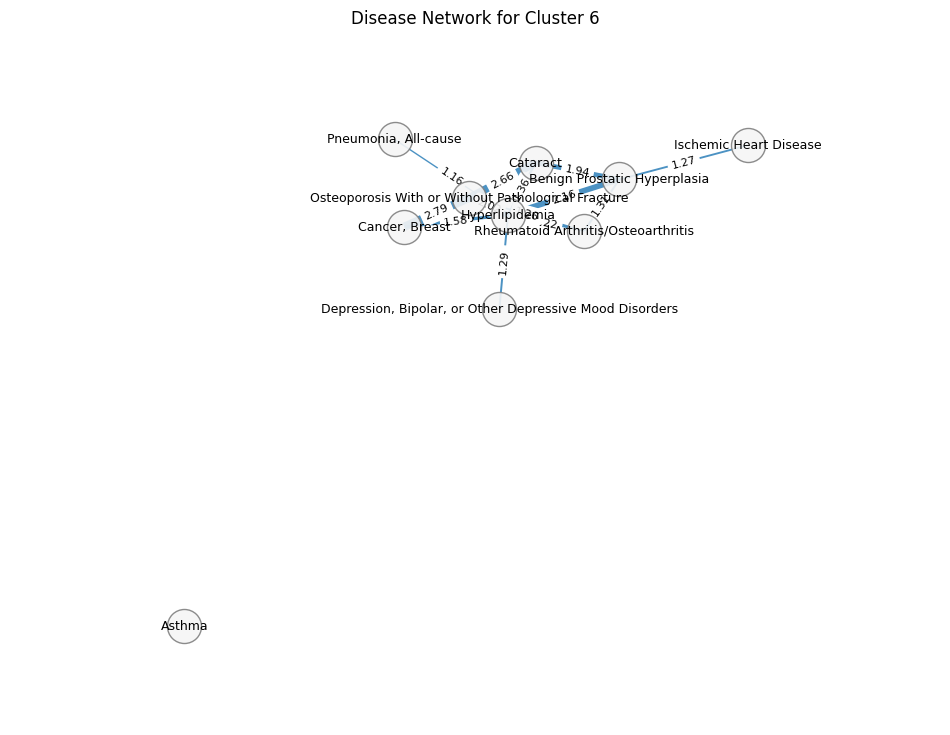

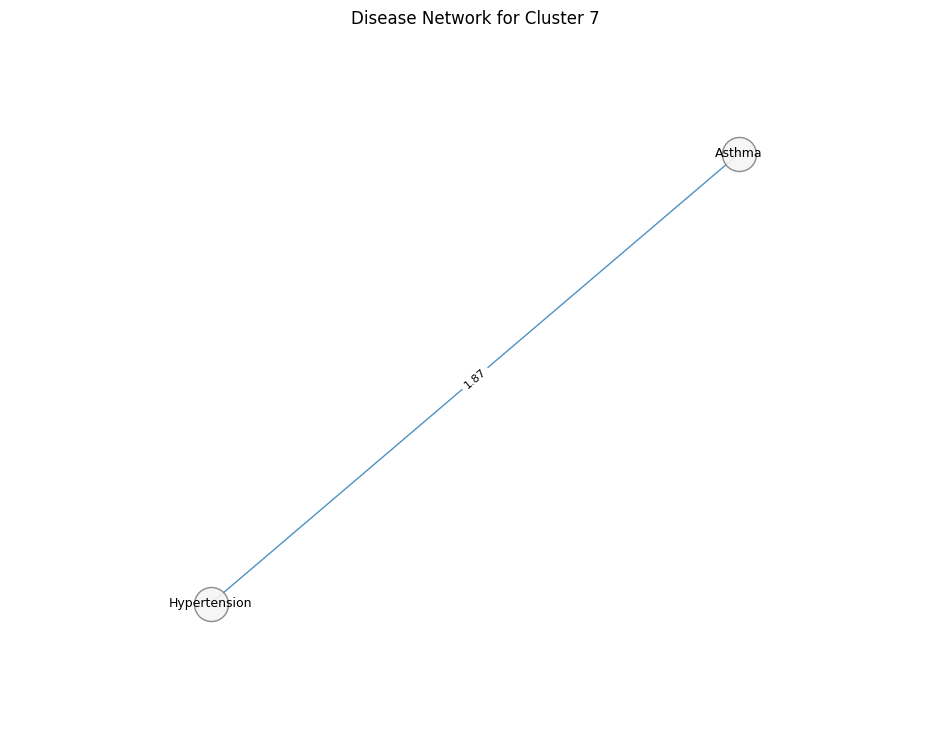

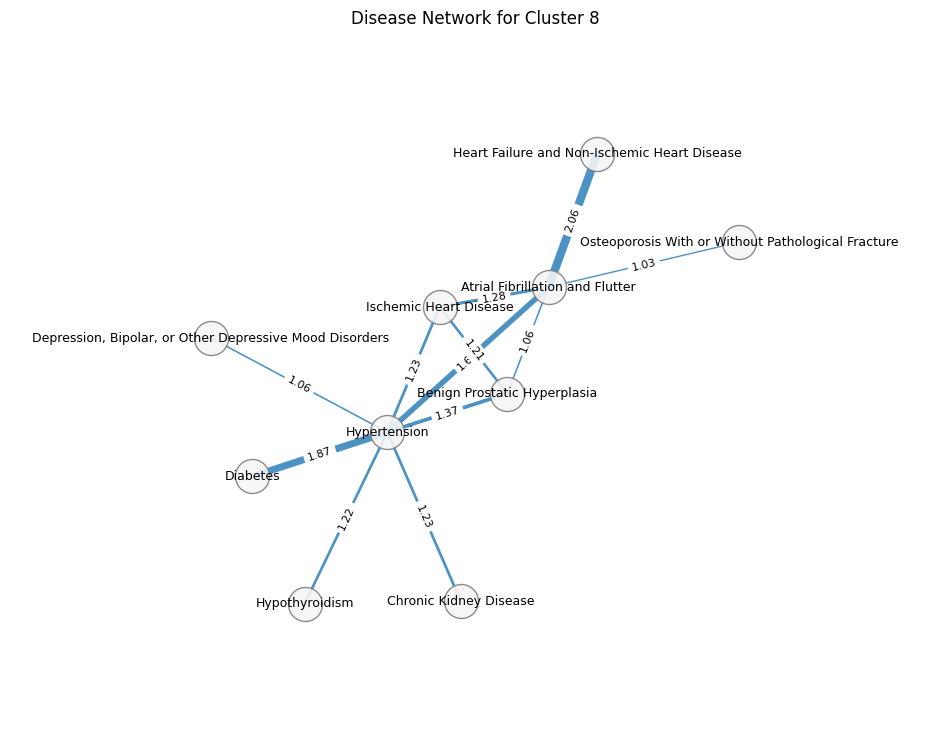

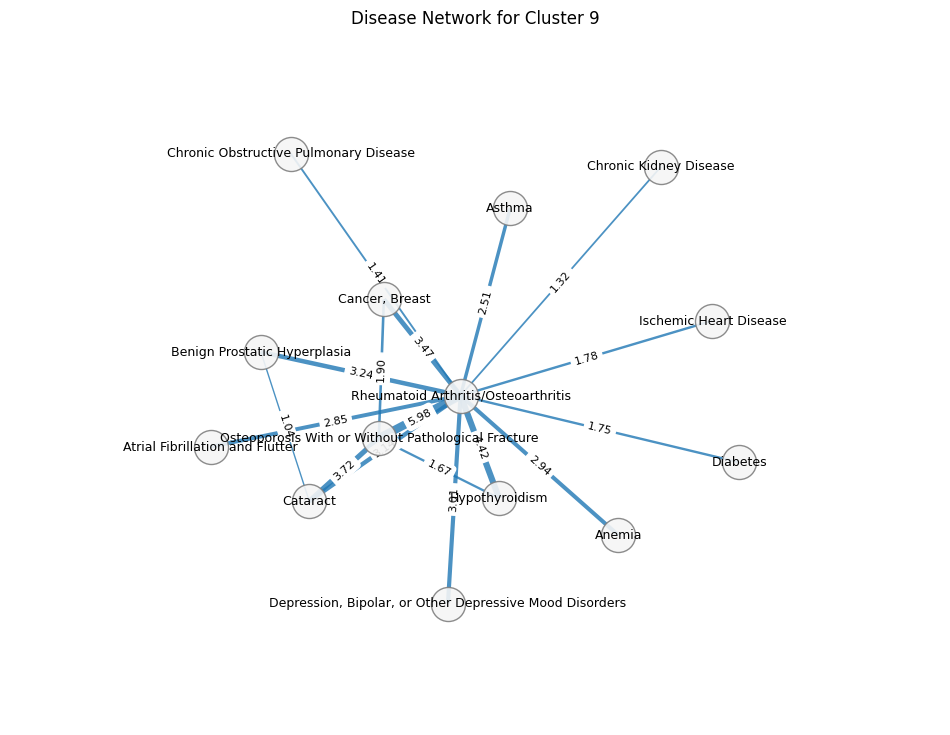

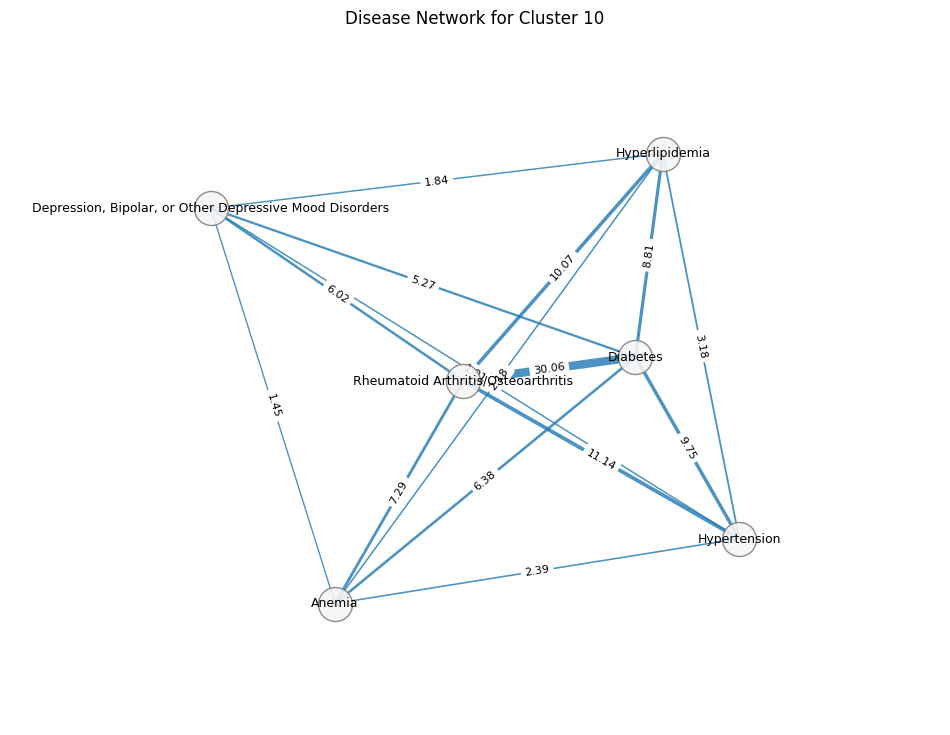

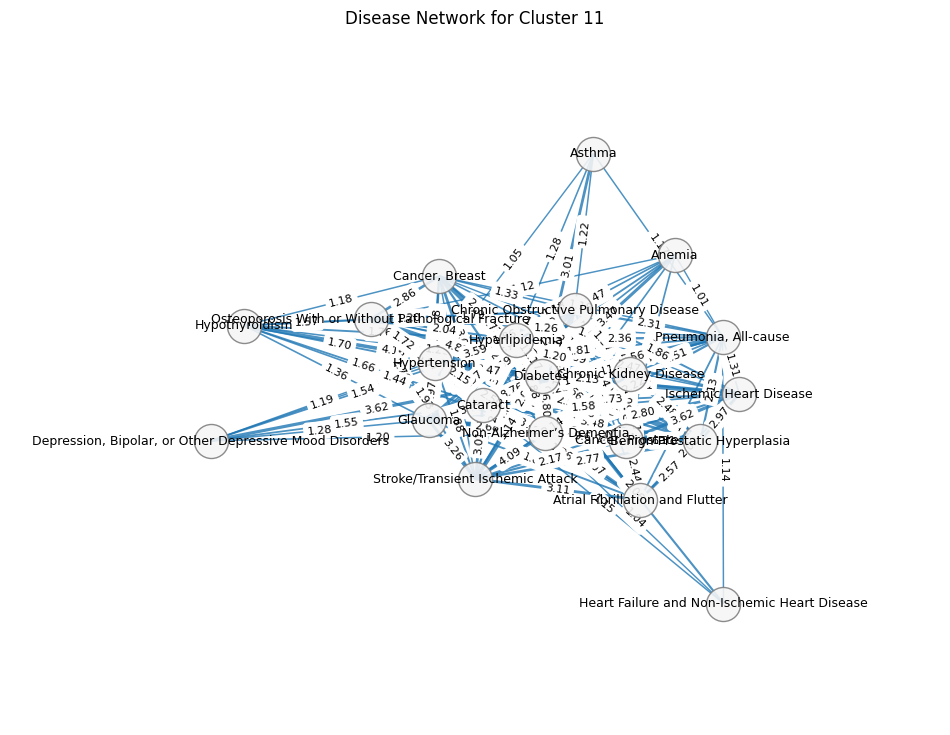

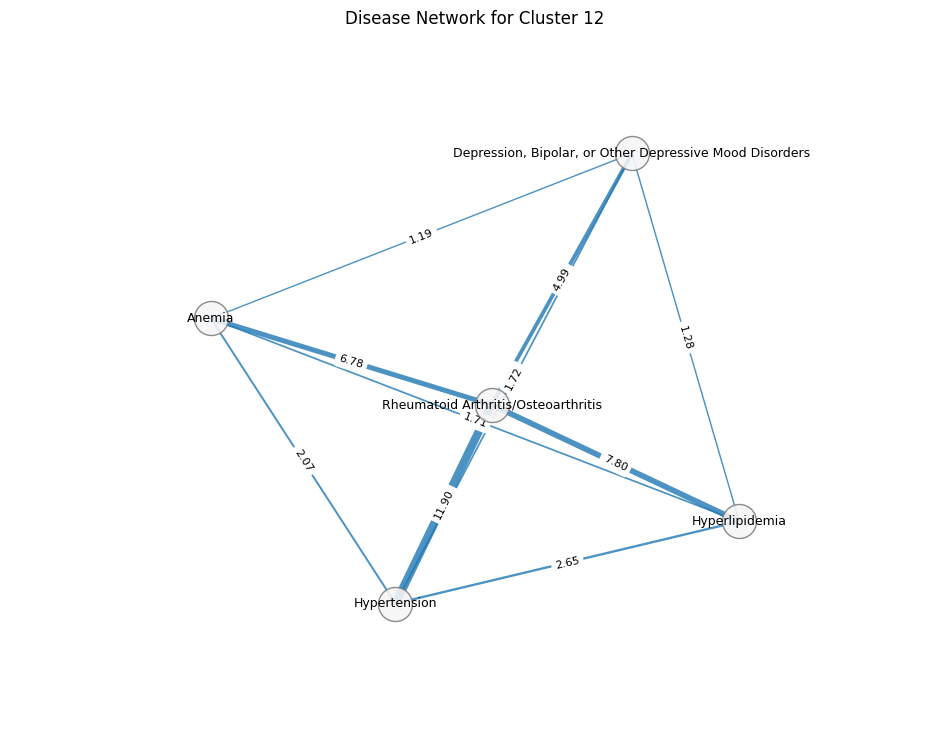

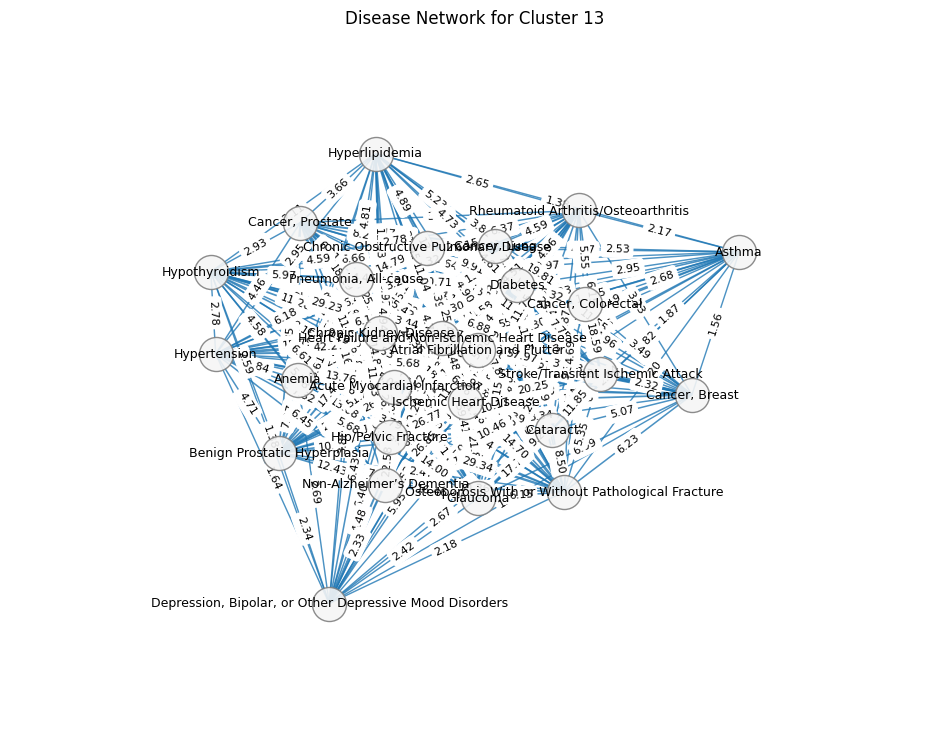

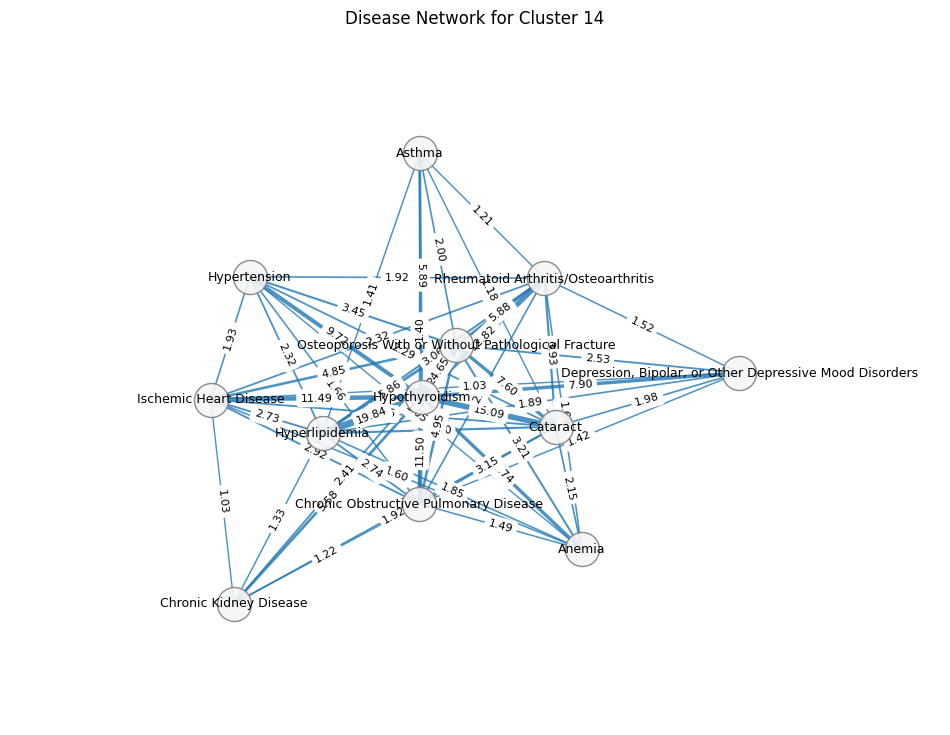

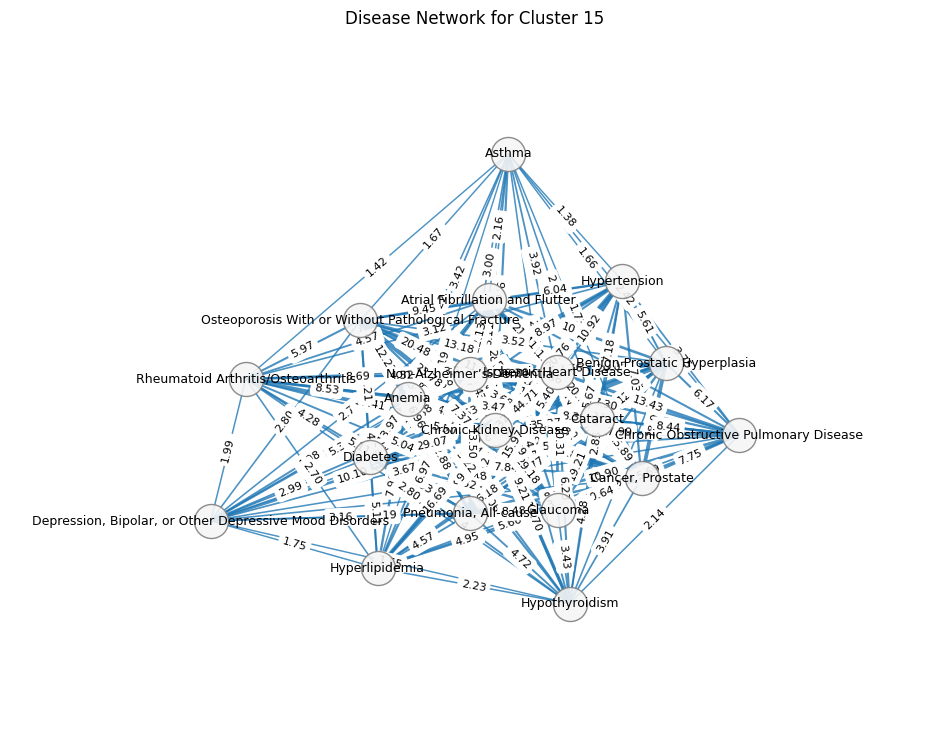

In [ ]:
plot_disease_graphs(oer_16_kmeans, disease_prevalence_kmeans, clust_size, prevalence_threshold=0.1)